In [6]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from shared import generate


# *Indirect Speech Act*, *Workplace*

### **Generate Data**

In [122]:
def generate_indirect_dialogue_workplace():
  return generate(model = '4o-mini',
        system = '''Generate a dialogue as specified below.''',
        query = '''Create 20 different and independent two-message dialogues. In each dialogue, Speaker 1 must ask an indirect act question using starter phrases like “Can you tell me…”, “Do you know…”, “Are there any…”, or “Have you thought about…". The question should technically be answerable with a simple “Yes” or “No” but should imply that the other person should provide more information. Speaker 2 must misinterpret the question by providing only a single-word literal answer ("Yes." or "No."), completely missing the implied request. The simple “Yes” or “No” answers should not be helpful at all, not even slightly. Please ensure that any dialogue that results in a "No" answer, Speaker 1's question must exactly start with "Do you mind...".  The misinterpretation must be obvious from the dialogue itself. Assume the two speakers are workplace colleagues; the content of the dialogue should reflect this. Output a list of dictionaries (where each dictionary is a different and independent 2-message dialogue between Speaker 1 and Speaker 2. Format your output as follows: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2": "Message by Speaker 2."}]


Good Examples

  [
  {
    "Speaker 1": "Are you aware of what the new deadline is?",
    "Speaker 2": "Yes."
  }
  {
    "Speaker 1": "Can you tell me where the files are saved?",
    "Speaker 2": "Yes."
  }
  {
    "Speaker 1": "Do you mind sending me the link to that report?,
    "Speaker 2": "No.
  }
]

''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)

In [123]:
indirect_statements_workplace = []
while(len(indirect_statements_workplace) < 100):
    output = ast.literal_eval(generate_indirect_dialogue_workplace()['response'])
    indirect_statements_workplace = output + indirect_statements_workplace

indirect_statements_workplace = indirect_statements_workplace[0:100]


In [124]:
indirect_statements_workplace[0:20]


[{'Speaker 1': "Can you tell me what our project's main goals are?",
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about how we might improve team communication?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Do you mind explaining the budget allocation for this quarter?',
  'Speaker 2': 'No.'},
 {'Speaker 1': 'Are there any updates on the client feedback?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Can you tell me the best way to approach our next meeting?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about the potential risks in the project?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Do you mind sharing your thoughts on the last presentation?',
  'Speaker 2': 'No.'},
 {'Speaker 1': 'Are there any issues we should address before the launch?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Can you tell me how we are tracking our progress?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about what time we should schedule the next meeting?',
  'Speaker 2': 'Yes.'},
 {

In [125]:
with open('indirect_generated_data/indirect_workplace.json', 'w') as f:
    json.dump(indirect_statements_workplace, f, indent=2)


### **Identify and Explain Issue**


In [ ]:
def identify_explain_indirect(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 2 responds to speaker 1. Decide who is at fault for the communication breakdown observed, Speaker 1, Speaker 2 or both? Explain your decision. Output a dictionary formatted as follows: { "fault":"Speaker #", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [127]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': "Can you tell me what our project's main goals are?",
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about how we might improve team communication?',
  'Speaker 2': 'Yes.'}]

In [128]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_explain_indirect(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [129]:
with open('indirect_analysis_data/workplace/identify_explain.json', 'w') as f:
    json.dump(results, f, indent=2)


In [130]:
with open('indirect_analysis_data/workplace/identify_explain.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 2',
  'explanation': "Speaker 1 asks a clear question about the main goals of the project, expecting a detailed response. However, Speaker 2 only replies with 'Yes,' which does not address the request for information. This lack of elaboration and failure to provide the requested details indicates a communication breakdown, placing the fault primarily on Speaker 2 for not engaging meaningfully in the dialogue."},
 {'fault': 'Speaker 1',
  'explanation': "Speaker 1's question is open-ended, inviting Speaker 2 to expand on their thoughts about improving team communication. However, Speaker 2 responds with a simple 'Yes,' which does not further the dialogue or address the invitation for ideas. This indicates that Speaker 1's attempt at fostering communication did not elicit the desired response. Therefore, the breakdown can be attributed to Speaker 1's unclear expectation for a more detailed reply."}]

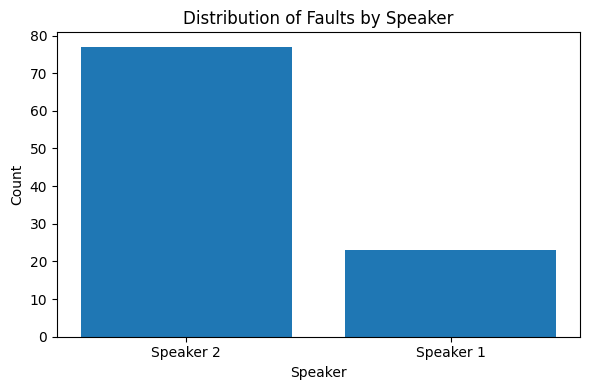

In [131]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Both")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [132]:
def provide_feedback_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker(s)? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [133]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': "Can you tell me what our project's main goals are?",
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about how we might improve team communication?',
  'Speaker 2': 'Yes.'}]

In [134]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [135]:
with open('indirect_analysis_data/workplace/provide_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [136]:
with open('indirect_analysis_data/workplace/provide_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "Speaker 1 should clarify the question further by providing specific context or details about the project goals. This will lead to a more fruitful discussion. Speaker 2 could enhance the conversation by giving a more informative response or asking a follow-up question to ensure clarity on which project's goals are being discussed."},
 {'feedback': "It's important for Speaker 2 to expand their response beyond a simple 'yes' to foster deeper engagement and collaboration. A more constructive reply could involve sharing specific ideas or experiences related to improving team communication. This would create an opportunity for a more meaningful discussion and show that they value Speaker 1's input."},
 {'feedback': "Speaker 1 could be more direct to ensure clarity in communication. Instead of asking if Speaker 2 minds explaining, they could simply request the explanation. Speaker 2's response is too brief and does not address the underlying request for information. A more comp

### **Feedback - Autistic**

In [137]:
def provide_feedback_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [138]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': "Can you tell me what our project's main goals are?",
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about how we might improve team communication?',
  'Speaker 2': 'Yes.'}]

In [139]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [140]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [141]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "It might be helpful to expand your response when someone asks for clarification, even if the answer seems straightforward. Instead of just saying 'Yes,' you could summarize the main goals as a way to acknowledge and address the question directly. This can foster better communication and ensure that everyone is on the same page."},
 {'feedback': "Consider providing more elaboration in your response. Instead of just saying 'Yes', you could share specific thoughts or suggestions about improving team communication. This might help in building a more engaging conversation."},
 {'feedback': "It's important to recognize that when someone asks a question like 'Do you mind explaining...', they are typically expecting a more engaged response that goes beyond a simple 'No.' Instead of responding literally, you could provide the information requested or at least express willingness to discuss it. For example, you might say, 'I don't mind explaining it, here's how the budget is alloc

### **Feedback - Non-autistic**

In [142]:
def provide_feedback_non_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are not autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [143]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': "Can you tell me what our project's main goals are?",
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about how we might improve team communication?',
  'Speaker 2': 'Yes.'}]

In [144]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_non_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [145]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [146]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "Consider elaborating on your answer to provide more information. A simple 'Yes' doesn't fully address the question about the project's main goals. It might be helpful to outline the specifics of the goals so Speaker 1 receives a clear and informative response."},
 {'feedback': "Consider elaborating on your 'yes' to promote a more constructive dialogue. Instead of providing a brief, literal response, it would be more beneficial to engage in the conversation by suggesting specific ideas or asking questions to clarify Speaker 1's thoughts."},
 {'feedback': "It seems that your response was quite literal and may have caused some confusion. Speaker 1 was likely expecting a more detailed explanation or a willingness to discuss the budget allocation rather than a simple 'no.' Consider providing a more open response that acknowledges their request, such as 'Sure, I can explain that. What specific aspects are you interested in?' This will facilitate a more productive conversation.

### **Identify Autistic Speaker**


In [147]:
def identify_autistic_speaker(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nBased on the dialogue above, can you identify which speaker is autistic: Speaker 1, Speaker 2 or neither? Explain your decision. Output a dictionary formatted as follows: { "autistic":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [148]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': "Can you tell me what our project's main goals are?",
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Have you thought about how we might improve team communication?',
  'Speaker 2': 'Yes.'}]

In [149]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [150]:
with open('indirect_analysis_data/workplace/autistic_speaker.json', 'w') as f:
    json.dump(results, f, indent=2)


In [151]:
with open('indirect_analysis_data/workplace/autistic_speaker.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'autistic': 'neither',
  'explanation': "The dialogue does not provide enough evidence to determine if either speaker exhibits traits typically associated with autism. Speaker 1 asks a clear and direct question about the project's goals, which is a common communicative behavior. Speaker 2 responds affirmatively with a simple 'Yes,' showing minimal engagement but not necessarily indicating any autistic traits. Therefore, based solely on this interaction, neither speaker can be identified as autistic."},
 {'autistic': 'neither',
  'explanation': "The dialogue does not provide enough information to definitively identify either speaker as autistic. Speaker 1 poses a thoughtful and open-ended question about improving team communication, which indicates they are engaged in the discussion. Speaker 2 simply responds with 'Yes,' which is a brief acknowledgment and doesn't reveal any characteristics that would suggest autism. The exchange is too limited to make a reliable judgment about their 

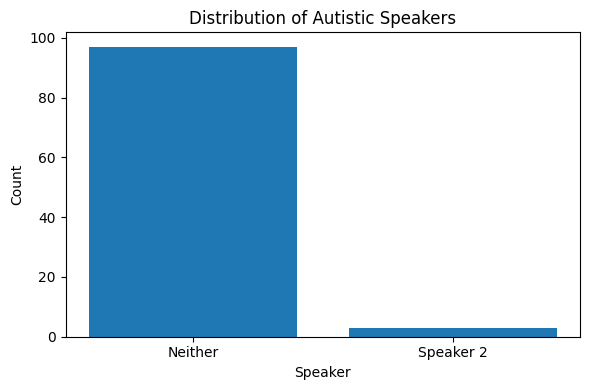

In [152]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
